In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

import numpy as np
np.set_printoptions(precision=2, linewidth=120, suppress=True, edgeitems=4)

import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 50)
#pd.set_option('precision', 5)

from datetime import datetime
from dateutil.parser import parse

from collections import defaultdict

from sklearn.cluster import KMeans

In [117]:
# import nltk
# from nltk.util import ngrams
# from collections import Counter
# from nltk.corpus import stopwords
# import string
# stopWords = stopwords.words('english') + list(string.punctuation)

# from nltk.probability import FreqDist
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem.porter import PorterStemmer
# from gensim import corpora, models
# import gensim
# from gensim.models import word2vec

In [7]:
# !pip list | grep jupyter # Check which version of pandas

In [3]:
os.chdir('/Users/zacklarsen/Dropbox/Inference Analytics Team Folder/Zack Work')
!ls *csv

AirbnbChicago.csv     CountDF.csv           Tuesday.csv
AirbnbLA.csv          LA_Crime.csv          kc_house_data.csv
AirbnbNYC.csv         OR.csv                neighborhoods.csv
AirbnbOakland.csv     Online Retail.csv     sample_submission.csv
AirbnbSF.csv          Ryder.csv             train_2016_v2.csv
AirbnbSanDiego.csv    Ryder_Failure.csv


In [4]:
pwd

'/Users/zacklarsen/Dropbox (Inference Analytics)/Inference Analytics Team Folder/Zack Work'

In [ ]:
os.chdir('')

## Online Retail dataset

### First, we need to clean the dataset up a bit

In [19]:
# OR = pd.read_csv('Online Retail.csv',parse_dates=['InvoiceDate'], dtype={'CustomerID': str})

# ## Remove invoice numbers beginning with 'C' for returns and 'A' for bad debt adjustments
# OR = OR.loc[~OR['InvoiceNo'].str.startswith("C")]
# OR = OR.loc[~OR['InvoiceNo'].str.startswith("A")]
# OR = OR[~OR['Description'].isnull()]
# OR = OR[OR['UnitPrice'] > 0] # Remove damaged products

# OR['D_O_W'] = OR['InvoiceDate'].apply(lambda x: x.weekday())
# OR['Date'] = OR['InvoiceDate'].apply(lambda x: x.date())

# ## Try to lowercase all descriptions
# OR['Description'] = OR['Description'].apply(lambda col: col.lower() if type(col) == str else None)

# ## Calculate invoice total
# OR['Total Amount'] = OR['Quantity']*OR['UnitPrice']

# OR.sort_values(['CustomerID','InvoiceNo'],ascending=[1,1],inplace=True)

# OR.to_csv('OR.csv')




# OR = pd.read_csv('OR.csv',dtype={'CustomerID': str})
# OR.drop('Unnamed: 0',axis=1,inplace=True) # Remove annoying index that excel creates
# OR['Date'] = pd.to_datetime(OR['Date']) # Convert date to datetime
# OR['Week'] = OR['Date'].dt.week # Obtain week number
# OR['Month'] = OR['Date'].dt.month # Obtain month number
# OR = OR[~OR['CustomerID'].isnull() ]
# OR.to_csv('OR.csv')

In [5]:
OR = pd.read_csv('OR.csv',dtype={'CustomerID': str})
OR.drop('Unnamed: 0',axis=1,inplace=True) # Remove annoying index that excel creates

OR.shape
OR.head()

(397884, 13)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,D_O_W,Date,Total Amount,Week,Month
0,541431,23166,medium ceramic top storage jar,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,1,2011-01-18,77183.6,3,1
1,537626,85116,black candelabra t-light holder,12,2010-12-07 14:57:00,2.10,12347,Iceland,1,2010-12-07,25.2,49,12
2,537626,22375,airline bag vintage jet set brown,4,2010-12-07 14:57:00,4.25,12347,Iceland,1,2010-12-07,17.0,49,12
3,537626,71477,colour glass. star t-light holder,12,2010-12-07 14:57:00,3.25,12347,Iceland,1,2010-12-07,39.0,49,12
4,537626,22492,mini paint set vintage,36,2010-12-07 14:57:00,0.65,12347,Iceland,1,2010-12-07,23.4,49,12


In [8]:
## See list of all weeks in dataset
# sorted(OR.Week.unique())

In [6]:
Items = OR.loc[:,['StockCode','Description']]
Items.sort_values(['StockCode'],inplace=True)
Items.drop_duplicates(inplace=True)
Items.reset_index(inplace=True)
Items.drop(['index'],inplace=True,axis=1)
Items.head()

,StockCode,Description
0,10002,inflatable political globe
1,10080,groovy cactus inflatable
2,10120,doggy rubber
3,10123C,hearts wrapping tape
4,10124A,spots on red bookcover tape


In [7]:
## This retrieves only the text description for the items with a certain StockCode number
Items.loc[Items['StockCode'] == 'POST', 'Description'].iloc[0]

'postage'

In [40]:
def binary(x):
## This function takes a dataframe with integer values and makes them binary
    if x > 0:
        return 1
    else:
        return 0

    
    
def one_hot(weekDF):
## One-hot encoding approach with StockCodes if argMAT == 'OH' ##
    OHDF = weekDF.loc[:,['CustomerID','StockCode']]
    cust_items = defaultdict(list)
    for i, j in zip(OHDF.CustomerID,OHDF.StockCode):
        cust_items[i].append(j)   
    items = cust_items.items()
    DD_DF = pd.DataFrame({'CustomerID': [i[0] for i in items], 'StockCodes': [i[1] for i in items]})
    s = pd.Series(DD_DF['StockCodes'])
    dumb = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
    customerDF = pd.merge(DD_DF,dumb,left_index = True,right_index = True)
    customerDF.drop(['StockCodes'],inplace=True,axis=1)
    customerDF.index = customerDF['CustomerID'] # Make the CustomerID the index to represent the 'document name'
    customerDF.drop(['CustomerID'],inplace=True,axis=1)        
    ## Here, we can using a map apply function to binarize the values
    customerDF.applymap(binary)
    return customerDF,OHDF

       
        
def TFIDF(weekDF,ng):
## TF-IDF approach with descriptions if argMAT == 'TFIDF' ##
    TFIDF = weekDF.groupby(['CustomerID'])['Description'].apply(lambda x: ' '.join(x)).reset_index()
    
    if ng == 1:
        v = TfidfVectorizer()  # unigrams
    else:
        v = TfidfVectorizer(ngram_range=(1,ng))  # unigrams, bigrams, and trigrams
                
    X = v.fit_transform(TFIDF['Description']).toarray()
    customerDF = pd.DataFrame() # Initialize new DF
    for i, col in enumerate(v.get_feature_names()):
        customerDF[col] = X[:, i]
        customerDF.index = DF['CustomerID'] # Make the CustomerID the index to represent the 'document name'
    return customerDF,TFIDF
      

def monthDF(DF,w):
    ## Here, we want to create another DF that has the month leading up to the current week so we can 
    ## lookup whether the customer has purchased that item in the last month, not just the past
    ## week.
    weeks = [w,w-1,w-2,w-3] # Current week AND three prior to it
    monthDF = DF[DF['Week'].isin(weeks)]
    cust_items = defaultdict(list)
    for i, j in zip(monthDF.CustomerID,monthDF.StockCode):
        cust_items[i].append(j) 
    
    return cust_items        
  
    

    
    
    
    
def cluster_assignments(customerDF,k,method):
    num_clusters = k        
    
    if method == 'kmeans':
        customer_km = KMeans(n_clusters=num_clusters)
        customer_km.fit(customerDF)
        customer_clusters = customer_km.labels_.tolist() 
        
        testDF = pd.DataFrame(customerDF.index)
        testDF['Cluster_Assignment'] = customer_clusters
        testDF.sort_values(['Cluster_Assignment','CustomerID'],ascending=[False,False],inplace=True)                           
        
    elif method == 'HAC':
        pass                        
    
    return testDF    
        
    
    
        
    
    
    
    
    
def iterate(TestDF,DF,k,cust_items):
    ## Here, we can iterate through all clusters:
    week_Table = []
    for j in range(1,k+1):
        clusterj = list(TestDF[TestDF['Cluster_Assignment'] == j]['CustomerID'])
        clusterjtrans = DF[DF['CustomerID'].isin(clusterj)]
        topn = clusterjtrans.StockCode.value_counts()
        topn = topn[:n] # These are the n top-selling items in this cluster
        ## Print results ##   
        for cust in clusterj:
            #print('________________')
            #print('Customer #',cust)
            for item in topn.index:        
                if item not in cust_items[str(cust)]:
                    #print('Item number:',item,Items.loc[Items['StockCode'] == item,'Description'].iloc[0])   
            #print('________________')
                    week_Table.append([w,j,cust,item])
    return week_Table
     

In [39]:
def dummyfunc(w,n,k,DF,argMAT,method,ng):
    Table = []
    weekDF = DF[DF['Week'] == w]
    
    if argMAT == 'TFIDF':
        customerDF,DF2 = TFIDF(weekDF,ng)
        #customerDF
    elif argMAT == 'OH':
        customerDF,DF2 = one_hot(weekDF)
        #customerDF
    else:
        print('Else')

    cust_items = monthDF(DF,4)

    TestDF = cluster_assignments(customerDF,k,method)
    #return TestDF
    
    
    cust_items = monthDF(DF,w)
    
    
    week_Table = iterate(TestDF,DF,k,cust_items)
    pd.merge(Table,week_Table)
    
    # Construct a dataframe out of the list of lists
    Table=pd.DataFrame(Table,columns=['Week','Cluster','CustomerID','StockCode']) 
    return Table
    

    
    
    
    
    
## Arguments ##
argMAT = 'OH' # Type of matrix to use for clustering. Either TFIDF or OH 
w = 40 # Week number
DF = OR # Original dataframe to use Must contain week, customerID, StockCode, Description
k = 10 # Number of clusters            
method = 'kmeans' # Clustering method
ng = 1 # Number of ngrams for TFIDF
n = 1
## Variables ##

    
Table = dummyfunc(w,n,k,DF,argMAT,method,ng)    
Table    

ValueError: can not merge DataFrame with instance of type <class 'list'>

## Cluster inspection and validation

In [101]:
from sklearn.cluster import KMeans
num_clusters = 4
customer_km = KMeans(n_clusters=num_clusters)
customer_km.fit(customerDF)
customer_clusters = customer_km.labels_.tolist()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [102]:
len(customer_clusters)

366

In [103]:
testDF = descriptions
testDF['Cluster_Assignment'] = customer_clusters
testDF.sort_values(['Cluster_Assignment','CustomerID'],ascending=[False,False],inplace=True)                 

In [106]:
testDF[testDF['Cluster_Assignment'] == 1]

,CustomerID,Description,Cluster_Assignment
365,18252,door hanger mum + dads room baking mould choc...,1
364,18241,6 ribbons rustic charm set of 6 ribbons vintag...,1
363,18210,embroidered ribbon reel emily embroidered rib...,1
362,18179,ivory kitchen scales round cake tin vintage re...,1
361,18149,jumbo bag red retrospot jumbo bag strawberry,1
360,18118,egg cup milkmaid ingrid egg cup milkmaid heidi...,1
359,18109,parisienne jewellery drawer set of tea coffee...,1
358,18102,black heart card holder wood black board ant w...,1
357,18077,large chinese style scissor small chinese styl...,1
356,18042,hot water bottle sex bomb clothes pegs retrosp...,1


In [ ]:
## Here, we want to create another DF that has the month leading up to the current week so we can 
## lookup whether the customer has purchased that item in the last month, not just the past
## week.
weeks = [w,w-1,w-2,w-3] # Current week AND three prior to it
monthDF = DF2[DF2['Week'].isin(weeks)]


from collections import defaultdict
cust_items = defaultdict(list)
for i, j in zip(monthDF.CustomerID,monthDF.StockCode):
    cust_items[i].append(j)
    
cust_items

## Below is code to automate the clustering by week for every week of year and the option to do either TF-IDF with product descriptions or one-hot encoding of StockCode

In [98]:
def recommender2(n,k,DF): 
    Table = [] # Initialize variable for the lookup table we wish to populate
    
    
    for w in range(1,52):  ## For every week of the year if range(1,52)
        ## Specify which week you want to look at, then subset data by that week
        weekDF = DF[DF['Week'] == w]
        
        
        
        ## TF-IDF approach with descriptions ##
#         descriptions = weekDF.groupby(['CustomerID'])['Description'].apply(lambda x: ' '.join(x)).reset_index()
#         from sklearn.feature_extraction.text import TfidfVectorizer
#         #v = TfidfVectorizer(ngram_range=(1,3))  # unigrams, bigrams, and trigrams
#         v = TfidfVectorizer()  # unigrams
#         X = v.fit_transform(descriptions['Description']).toarray()
#         customerDF = pd.DataFrame() # Initialize new DF
#         for i, col in enumerate(v.get_feature_names()):
#             customerDF[col] = X[:, i]
#         customerDF.index = descriptions['CustomerID'] # Make the CustomerID the index to represent the 'document name'
        
        ## One-hot encoding approach with StockCodes ##
        DF2 = DF.loc[:,['CustomerID','StockCode']]
        #DF7
        from collections import defaultdict
        cust_items = defaultdict(list)
        for i, j in zip(DF2.CustomerID,DF2.StockCode):
            cust_items[i].append(j)   
        #cust_items      
        items = cust_items.items()
        DD_DF = pd.DataFrame({'CustomerID': [i[0] for i in items], 'StockCodes': [i[1] for i in items]})
        #DD_DF.head(3)
        #DD_DF.shape
        s = pd.Series(DD_DF['StockCodes'])
        dumb = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
        customerDF = pd.merge(DD_DF,dumb,left_index = True,right_index = True)
        customerDF.drop(['StockCodes'],inplace=True,axis=1)
        customerDF.index = customerDF['CustomerID'] # Make the CustomerID the index to represent the 'document name'
        customerDF.drop(['CustomerID'],inplace=True,axis=1)


                
        from sklearn.cluster import KMeans
        num_clusters = k
        customer_km = KMeans(n_clusters=num_clusters)
        customer_km.fit(customerDF)
        customer_clusters = customer_km.labels_.tolist()
        testDF = customerDF
        testDF['Cluster_Assignment'] = customer_clusters
        testDF.sort_values(['Cluster_Assignment','CustomerID'],ascending=[False,False],inplace=True)                 
        ## Here, we want to create another DF that has the month leading up to the current week so we can 
        ## lookup whether the customer has purchased that item in the last month, not just the past
        ## week.
        weeks = [w,w-1,w-2,w-3] # Current week AND three prior to it
        monthDF = DF[DF['Week'].isin(weeks)]
        from collections import defaultdict
        cust_items = defaultdict(list)
        for i, j in zip(monthDF.CustomerID,monthDF.StockCode):
            cust_items[i].append(j)            
        #     from collections import defaultdict
        #     cust_items = defaultdict(list)
        #     for i, j in zip(DF.CustomerID,DF.StockCode):
        #         cust_items[i].append(j)            

        ## Here, we can iterate through all clusters:
        for j in range(1,k+1):
            clusterj = list(testDF[testDF['Cluster_Assignment'] == j]['CustomerID'])
            clusterjtrans = DF[DF['CustomerID'].isin(clusterj)]
            topn = clusterjtrans.StockCode.value_counts()
            topn = topn[:n] # These are the n top-selling items in this cluster
            ## Print results ##   
            for cust in clusterj:
                #print('________________')
                #print('Customer #',cust)
                for item in topn.index:        
                    if item not in cust_items[str(cust)]:
                        #print('Item number:',item,Items.loc[Items['StockCode'] == item,'Description'].iloc[0])   
                #print('________________')
                        Table.append([w,j,cust,item])

                    
                    
                    
    # Construct a dataframe out of the list of lists
    Table=pd.DataFrame(Table,columns=['Week','Cluster','CustomerID','StockCode']) 
    return Table

In [99]:
n = 5 # Set the number of top-selling products here
k = 10 # Number of clusters
DF = OR # Define dataframe to work from

Lookup_Table = recommender2(n,k,DF)

KeyError: 'CustomerID'

In [100]:
Lookup_Table.tail()

NameError: name 'Lookup_Table' is not defined

In [18]:
## Retrieve week #40 Customer #18257  (optionally) cluster #4
Lookup_Table.loc[(Lookup_Table['Week'] == 40) & (Lookup_Table['CustomerID'] == '18257')] #& (Lookup_Table['Cluster'] == 3)

,Week,Cluster,CustomerID,StockCode
37520,40,9,18257,47566
37521,40,9,18257,20725
37522,40,9,18257,82482
37523,40,9,18257,22382
37524,40,9,18257,23298


## Create customer descriptions DF

In [19]:
## This gives us a string with all descriptions for all invoices for all customers active in week w
descriptions = OR.groupby(['CustomerID'])['Description'].apply(lambda x: ' '.join(x)).reset_index()

# ## Create a dictionary of customerID,description pairs
# token_dict = pd.Series(descriptions['Description'].values,index=descriptions['CustomerID']).to_dict()


# ## Print first n (key,value) pairs in dictionary
# n = 3
# keys = sorted(token_dict.keys())

# {k: token_dict[k] for k in keys[:n]}

from sklearn.feature_extraction.text import TfidfVectorizer

# Use line below for just unigrams
#v = TfidfVectorizer()

# Use line below for unigrams, bigrams, and trigrams
v = TfidfVectorizer(ngram_range=(1,3))  

X = v.fit_transform(descriptions['Description']).toarray()

customerDF = pd.DataFrame() # Initialize new DF

for i, col in enumerate(v.get_feature_names()):
    customerDF[col] = X[:, i]

In [35]:
customerDF.index = descriptions['CustomerID'] # Make the CustomerID the index to represent the 'document name'
customerDF.head()
customerDF.shape

,10,10 advent,10 advent calendar,10 art,10 art lights,10 assorted,10 assorted colours,10 assorted creepy,10 balloon,10 balloon water,10 balloons,10 balloons 12,10 balloons 60,10 balloons bag,10 balloons balloon,10 balloons bingo,10 balloons blue,10 balloons brocade,10 balloons bundle,10 balloons chinese,10 balloons condiment,10 balloons decoration,10 balloons doormat,10 balloons emergency,10 balloons empire,10 balloons fairy,10 balloons feltcraft,10 balloons giant,10 balloons gingerbread,10 balloons girls,10 balloons grow,10 balloons gymkhana,10 balloons hairclips,10 balloons hand,10 balloons heart,10 balloons jazz,10 balloons jumbo,10 balloons large,10 balloons laurel,10 balloons lavender,10 balloons light,10 balloons love,10 balloons lunch,10 balloons manual,10 balloons mini,10 balloons pack,10 balloons panda,10 balloons paper,10 balloons party,10 balloons picture,10 balloons pink,10 balloons plasters,10 balloons popcorn,10 balloons retrospot,10 balloons rocket,10 balloons set,10 balloons sleeping,10 balloons smokey,10 balloons soldiers,10 balloons spaceboy,10 balloons strawberry,10 balloons toilet,10 balloons traditional,10 balloons vanilla,10 balloons vintage,10 balloons white,10 balloons wise,10 balloons wooden,10 balloons wrap,10 balloons writing,10 blue,10 blue diner,10 blue polkadot,10 bull,10 bull dog,...,box scandinavian,box scandinavian hearts,box scandinavian paisley,box scandinavian reds,box scottie,box scottie dog,box scotties,box scotties design,box seaside,box seaside flying,box set,box set 10,box set 12,box set 20,box set 36,box set 40,box set babushka,box set badges,box set bird,box set candles,box set christmas,box set collage,box set daisy,box set decoupage,box set dinosaur,box set football,box set frog,box set fruit,box set nursery,box set ocean,box set of,box set pantry,box set paper,box set piggy,box set pink,box set pot,box set purple,box set red,box set retrospot,box set rose,box set school,box set skull,box set spring,box set tea,box set turquoise,box set valentine,box set vanilla,box set white,box set wicker,box set3,box set3 book,box sewing,box sewing box,box sewing susan,box shoe,box shoe shine,box sign,box sign home,box silicon,box silicon star,box silver,box silver assorted,box silver bells,box silver diamante,box silver doughnut,box silver fabric,box silver fishing,box silver georgian,box silver glitter,box silver hanging,box silver hearts,box silver ivory,box silver jewelled,box silver large,box silver lariat
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12957,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12956,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12955,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

(4338, 40201)

### Alternatively, we can create a customerDF matrix by one-hot encoding the StockCode number instead of description

In [21]:
len(OR.StockCode.unique())

3665

In [41]:
DF7 = OR.loc[:,['CustomerID','StockCode']]
#DF7
from collections import defaultdict
cust_items = defaultdict(list)
for i, j in zip(DF7.CustomerID,DF7.StockCode):
    cust_items[i].append(j)   

#cust_items      

items = cust_items.items()
DD_DF = pd.DataFrame({'CustomerID': [i[0] for i in items], 'StockCodes': [i[1] for i in items]})
#DD_DF.head(3)
#DD_DF.shape

s = pd.Series(DD_DF['StockCodes'])
dumb = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)

customerDF = pd.merge(DD_DF,dumb,left_index = True,right_index = True)
customerDF.drop(['StockCodes'],inplace=True,axis=1)

customerDF.index = customerDF['CustomerID'] # Make the CustomerID the index to represent the 'document name'
customerDF.drop(['CustomerID'],inplace=True,axis=1)

In [42]:
customerDF.head(5)
# customerDF.shape

# ## See how many times each product StockCode has been purchased
# customerDF.sum(axis=0)

,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,15030,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16010,16011,16012,16014,16015,16016,16020C,16033,16043,16045,16046,16048,16049,16052,16054,16151A,16156L,16156S,16161G,16161M,16161P,16161U,16162L,16162M,16168M,16169E,16169K,16169M,16169N,16169P,16202A,16202B,16202E,16206B,16207A,16207B,16216,16218,16219,16225,16235,16236,16237,16238,16244B,16248B,16254,16258A,16259,...,90190C,90191,90192,90194,90195A,90195B,90196A,90196B,90197B,90198A,90198B,90199A,90199B,90199C,90199D,90200A,90200B,90200C,90200D,90200E,90201A,90201B,90201C,90201D,90202A,90202B,90202C,90202D,90204,90205A,90205C,90206A,90206C,90208,90209A,90209B,90209C,90210A,90210B,90210C,90210D,90211A,90211B,90212B,90212C,90214A,90214B,90214C,90214D,90214E,90214F,90214G,90214H,90214I,90214J,90214K,90214L,90214M,90214N,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [29]:
from sklearn.cluster import KMeans
num_clusters = 10
customer_km = KMeans(n_clusters=num_clusters)
customer_km.fit(new_DF)
customer_clusters = customer_km.labels_.tolist()



testDF = descriptions
testDF['Cluster_Assignment'] = customer_clusters
testDF.sort_values(['Cluster_Assignment','CustomerID'],ascending=[False,False],inplace=True)
testDF.head(10)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [33]:

cluster1 = list(testDF[testDF['Cluster_Assignment'] == 1]['CustomerID'])
#cluster1


## Find transactions for customers in this cluster
cluster1trans = OR[OR['CustomerID'].isin(cluster1)]

#cluster1trans

In [34]:
n = 4 # Set the number of top-selling products here

topn = cluster1trans.StockCode.value_counts()
topn = topn[:n] # These are the n top-selling items in this cluster


## Create data structure with a list of item StockCode numbers per customer
from collections import defaultdict
cust_items = defaultdict(list)
for i, j in zip(OR.CustomerID,OR.StockCode):
    cust_items[i].append(j)
    

    
## For each customer in the cluster, if they have not purchased the top n products, 
## recommend those products to the customer

for cust in cluster1:
    for item in topn.index:        
        if item not in cust_items[str(cust)]:
            print(cust,item)       

17140 85123A
17140 47566
17140 20725
17139 47566
17138 85123A
17138 20725
17135 85123A
17135 22423
17135 47566
17135 20725
17134 22423
17134 47566
17134 20725
17133 22423
17133 20725
17131 22423
17131 47566
17131 20725
17128 22423
17128 47566
17128 20725
17126 22423
17126 47566
17126 20725
17125 85123A
17125 47566
17125 20725
17124 85123A
17124 22423
17124 20725
17123 22423
17123 47566
17123 20725
17122 85123A
17122 22423
17122 47566
17122 20725
17120 20725
17119 85123A
17119 22423
17119 47566
17119 20725
17118 85123A
17118 22423
17118 47566
17117 85123A
17117 22423
17117 47566
17117 20725
17114 47566
17114 20725
17111 85123A
17111 22423
17111 47566
17111 20725
17110 85123A
17110 47566
17110 20725
17109 85123A
17109 22423
17109 20725
17105 85123A
17105 47566
17105 20725
17102 85123A
17102 22423
17102 47566
17102 20725
17101 85123A
17101 22423
17101 47566
17101 20725
17100 85123A
17100 22423
17100 47566
17100 20725
17097 22423
17097 20725
17096 22423
17096 47566
17096 20725
17095 85123A

## Plot the dendrogram of all the customers

In [17]:
## Compute the distance matrix from the TF-IDF matrix

from sklearn.metrics.pairwise import cosine_similarity
customer_dist = 1 - cosine_similarity(customerDF)

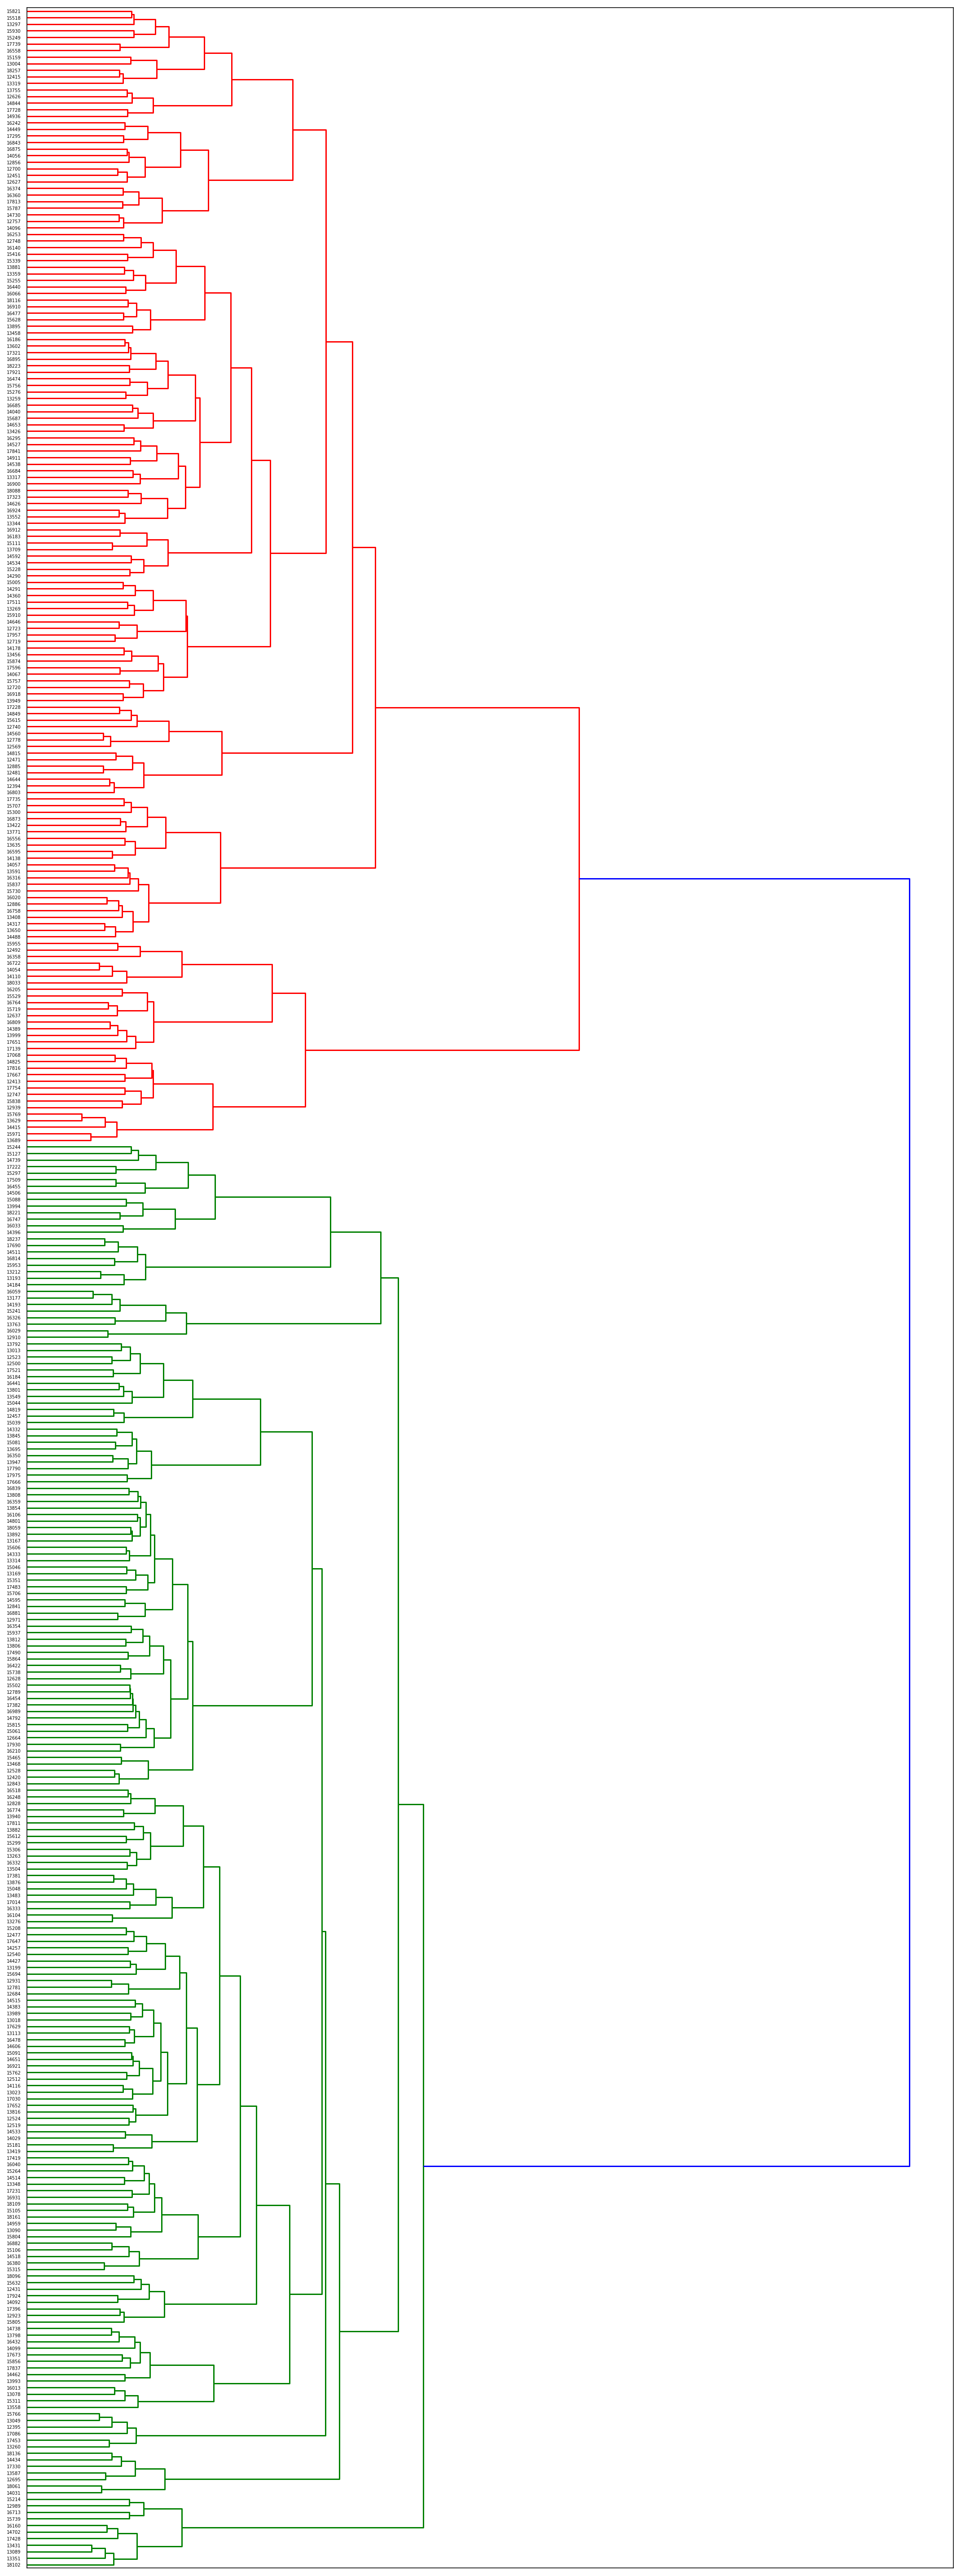

In [18]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(customer_dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 40)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=customerDF.index);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout


#uncomment below to save figure
plt.savefig('customer_ward_clusters.png', dpi=200) #save figure as ward_clusters

## Create product DF

In [19]:
## Create a list of UNIQUE products and their associated descriptions so we can create categories
Products = OR.loc[:,['StockCode','Description']].sort_values(by='StockCode')
Products.drop_duplicates(inplace=True)
Products.reset_index(inplace=True)
Products.drop('index',inplace=True,axis=1)

In [20]:
Products.head(5)

,StockCode,Description
0,10120,doggy rubber
1,10125,mini funky design tapes
2,10135,colouring pencils brown tube
3,11001,asstd design racing car pen
4,15034,paper pocket traveling fan


In [21]:
Products.shape  ## 3897 stock codes

(2023, 2)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(ngram_range=(1,3)) # Unigrams, bigrams, and trigrams


X = v.fit_transform(Products['Description']).toarray()
DF = pd.DataFrame()

for i, col in enumerate(v.get_feature_names()):
    DF[col] = X[:, i]
    
DF.index = Products.StockCode # Make the stock code the index to represent the 'document name'
#DF

In [23]:
DF.shape
DF.index

(2023, 9226)

Index(['10120', '10125', '10135', '11001', '15034', '15036', '15044C',
       '15044D', '15056BL', '15056N',
       ...
       '90200E', '90201A', '90201B', '90201C', '90201D', '90214A', 'C2', 'DOT',
       'M', 'POST'],
      dtype='object', name='StockCode', length=2023)

In [24]:
## Now that we have the TF-IDF matrix, let's compare similarity of the different stock numbers

DF.iloc[1,:10]

10                    0.0
10 balloons           0.0
10 blue               0.0
10 blue polkadot      0.0
10 colour             0.0
10 colour spaceboy    0.0
10 ivory              0.0
10 ivory polkadot     0.0
10 lanterns           0.0
10 lanterns fairy     0.0
Name: 10125, dtype: float64

## Now that we have the TF-IDF matrix, let's cluster

In [25]:
from sklearn.cluster import KMeans

num_clusters = 9

km = KMeans(n_clusters=num_clusters)

km.fit(DF)

clusters = km.labels_.tolist()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [26]:
testDF2 = Products

In [27]:
testDF2['Cluster_Assignment'] = clusters

testDF2.sort_values('Cluster_Assignment',ascending=False,inplace=True)

testDF2

,StockCode,Description,Cluster_Assignment
1660,35471D,set of 3 bird light pink feather,8
724,22398,magnets pack of 4 swallows,8
1406,23268,set of 2 ceramic christmas reindeer,8
1407,23269,set of 2 ceramic christmas trees,8
1408,23270,set of 2 ceramic painted hearts,8
792,22489,pack of 12 traditional crayons,8
793,22491,pack of 12 coloured pencils,8
1413,23275,set of 3 hanging owls ollie beak,8
1017,22759,set of 3 notebooks in parcel,8
797,22495,set of 2 round tins camembert,8


In [28]:
testDF2[testDF2['Cluster_Assignment'] == 8]


,StockCode,Description,Cluster_Assignment
1660,35471D,set of 3 bird light pink feather,8
724,22398,magnets pack of 4 swallows,8
1406,23268,set of 2 ceramic christmas reindeer,8
1407,23269,set of 2 ceramic christmas trees,8
1408,23270,set of 2 ceramic painted hearts,8
792,22489,pack of 12 traditional crayons,8
793,22491,pack of 12 coloured pencils,8
1413,23275,set of 3 hanging owls ollie beak,8
1017,22759,set of 3 notebooks in parcel,8
797,22495,set of 2 round tins camembert,8


In [29]:
## Compute the distance matrix from the TF-IDF matrix

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(DF)

## Below is a plot for the dendrogram of the hierarchical clusters
### http://brandonrose.org/clustering

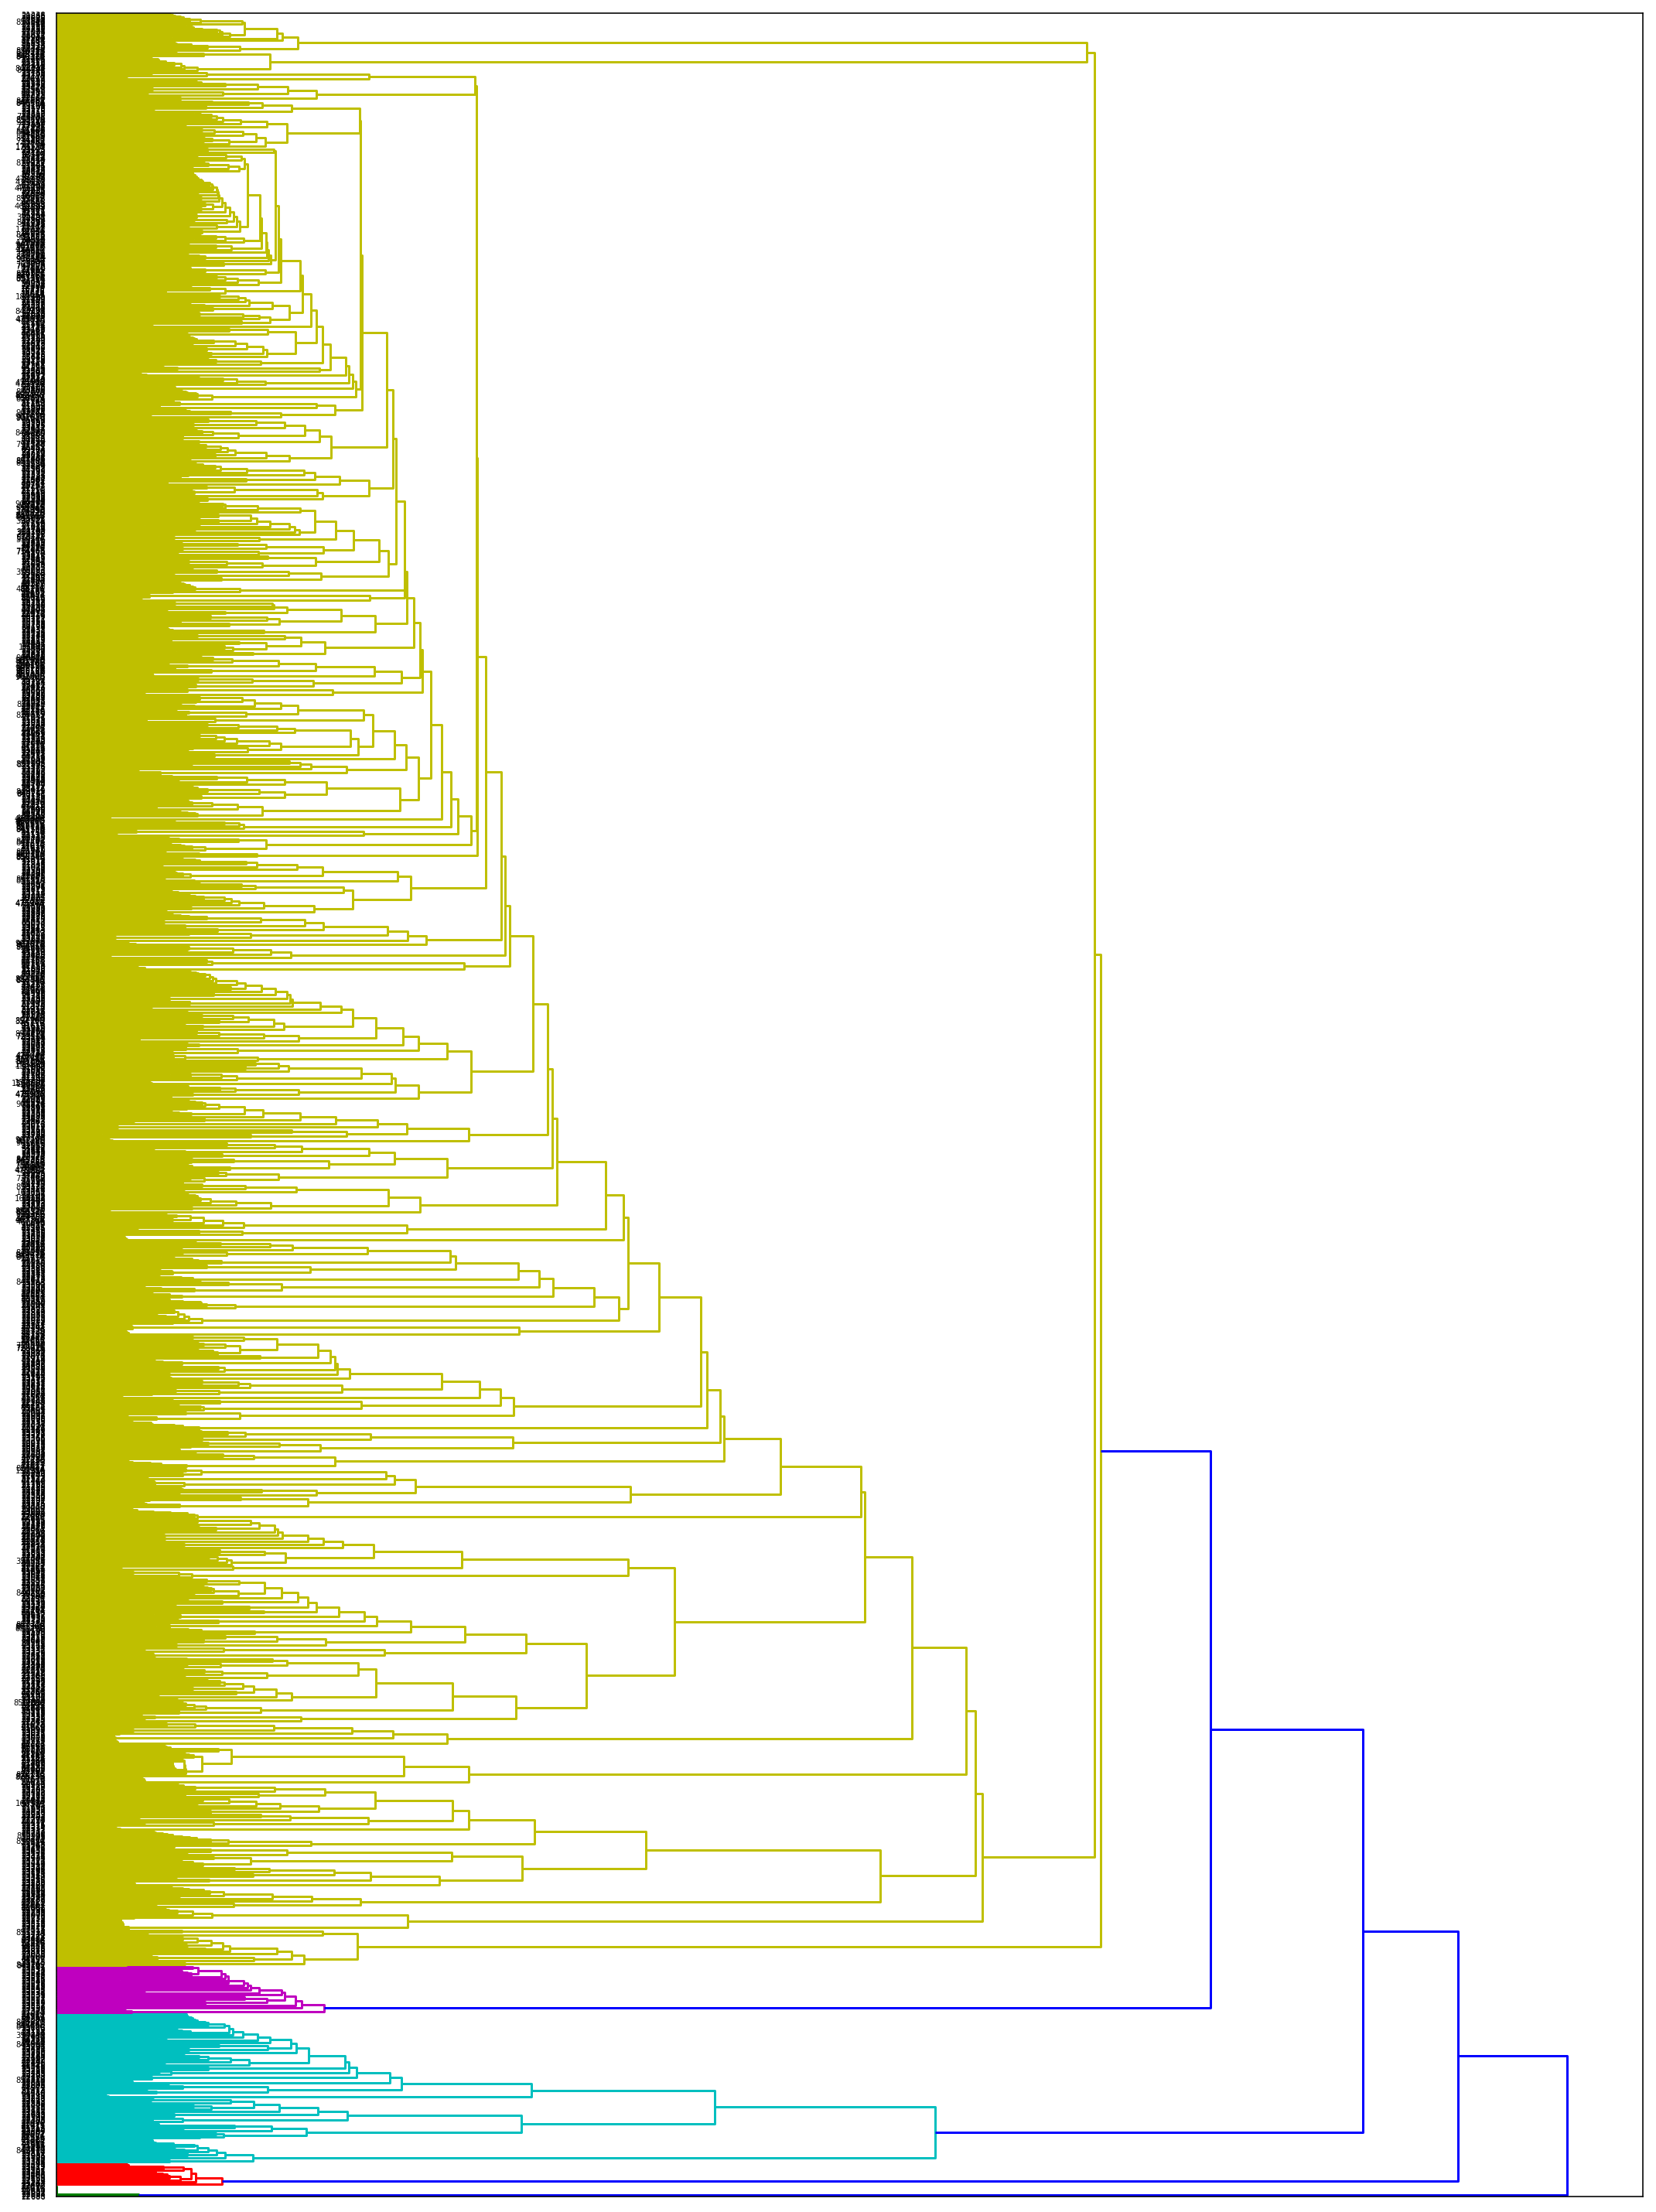

In [30]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=DF.index);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [281]:
plt.close()